In [1]:
from fairseq import checkpoint_utils
import torch
hubert,_,_ = checkpoint_utils.load_model_ensemble_and_task(
    ["./hubert_base.pt"],
    suffix="",
)
hubert_model = hubert[0]
hubert_model = hubert_model.half()

# Create a Adapter model
class HuberAdapter(torch.nn.Module):
    def __init__(self, model):
        super(HuberAdapter, self).__init__()
        self.model = model
    def forward(self,feats,padding_mask):
        inputs = {
            "source": feats,
            "padding_mask": padding_mask,
            "output_layer": 12
        }
        return self.model.extract_features(**inputs)

# Loading presaved feats and padding mask
feats = torch.load("./feats.pt")
padding_mask = torch.load("./padding_mask.pt")

2025-02-18 07:12:08 | INFO | fairseq.tasks.text_to_speech | Please install tensorboardX: pip install tensorboardX
/usr/local/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-18 07:12:09 | INFO | fairseq.tasks.hubert_pretraining | current directory is /root
2025-02-18 07:12:09 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': 'metadata', 'fine_tuning': False, 'labels': ['km'], 'label_dir': 'label', 'label_rate': 50.0, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2025-02-18 07:12:09 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'labe

In [2]:
adapter = HuberAdapter(hubert_model.cuda())

In [3]:
output = adapter(feats,padding_mask)

In [4]:
output[0].shape

torch.Size([1, 100, 768])

In [5]:
output[1].shape

torch.Size([1, 100])

In [6]:
output[0]

tensor([[[-0.0973, -0.0058,  0.0375,  ..., -0.0207,  0.0184, -0.0429],
         [ 0.0897, -0.0811, -0.3062,  ..., -0.0723, -0.0154,  0.0751],
         [ 0.0923, -0.1959, -0.3440,  ..., -0.1028,  0.0982,  0.0627],
         ...,
         [-0.1334,  0.1582, -0.5205,  ...,  0.1016,  0.3640,  0.1255],
         [-0.0876,  0.1980, -0.1119,  ...,  0.1500,  0.3696,  0.1107],
         [ 0.0884,  0.0048, -0.2225,  ..., -0.0490, -0.0677, -0.1818]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<TransposeBackward0>)

In [7]:
import librosa

wav,_ = librosa.load("./tts.wav",sr=16000)

In [8]:
wav

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

关于下面使用的ONNX模型，可前往Xenova的[HuggingFace仓库](https://huggingface.co/Xenova/hubert-base-ls960)克隆，或使用HuggingFace CLI下载

In [9]:
import onnxruntime as ort

model = ort.InferenceSession("./model_quantized.onnx",providers=["CPUExecutionProvider"])

In [10]:
import numpy as np
wav = np.expand_dims(wav,axis=0)

In [11]:
wav

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [12]:
output_onnx = model.run(
    ["last_hidden_state"],
    {"input_values":feats.float().cpu().numpy()}
)[0]

In [13]:
output_onnx.shape

(1, 100, 768)

In [23]:
np.squeeze(output_onnx)[0].shape

(768,)

In [31]:
output[0].squeeze()[0].shape

torch.Size([768])

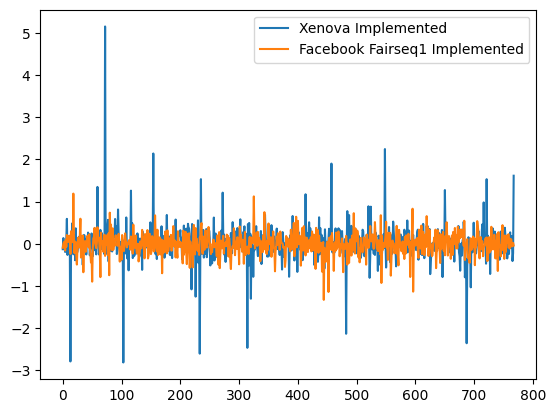

In [32]:
import matplotlib.pyplot as plt
plt.plot(np.squeeze(output_onnx)[0],label="Xenova Implemented")
plt.plot(output[0].squeeze().detach()[0].cpu().numpy(),label="Facebook Fairseq1 Implemented")
plt.legend()
plt.show()